# Визуализация результатов имитационной модели

В этом ноутбуке обработаем данные, полученные в результате выполнения
имитационной модели.

Сам запуск имитационной модели требует очень большого количества времени и
производится отдельно. Для этого нужно:

> **TODO**: описать, как запустить имитационную модели

## Настройка ноутбука

In [44]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d
from typing import Sequence, Union

from utility.jupyter_helpers import setup_matplotlib, get_color, savefig

In [46]:
# Настраиваем matplotlib
%matplotlib inline
setup_matplotlib()

## Параметры окружения и вспомогательные функции

Определим параметры окружения:

- параметры протокола, которые мы будем исползовать по-умолчанию
- набор файлов с данными симуляции. 

Файлы с данными симуляции должны быть в формате CSV и иметь колонки:

- `index`: номер (ID) записи
- `angle`: угол наклона антенны считывателя в радианах
- `doppler`: моделировался ли эффект Доплера (`True` или `False`)
- `frequency`: частота в герцах
- `inventory_prob`: вероятность того, что метка успешно передала EPCID
- `m`: тип кодирования (`"FM0"`, `"M2"`, `"M4"`, `"M8"`)
- `orientation`: сторона номера с меткой (`"front"` или `"back"`)
- `q`: значение Q-параметра
- `read_tid_prob`: вероятность успешной передачи TID
- `rounds_per_tag`: в скольких раундах участвовала метка
- `speed`: скорость метки в км/ч
- `tari`: значение параметра Tari в секундах
- `trext`: использовалась ли расширенная преамбула (`True` или `False`)

Столбцы с вероятностями идентификации: `inventory_prob`, `read_tid_prob`.

In [47]:
DATA_DIR = 'data'  # где хранятся все данные

# Перечислим те файлы, из которых будут браться результаты.
DATA_FILES = [
    '2017_results-5000-50_70.csv',
    '2017_results-5000-70_90.csv',
    '2017_results-5000-90_110.csv',
    '2017_results-5000-110_130.csv',
]

DATA_PATHS = [os.path.join(DATA_DIR, fname) for fname in DATA_FILES]

# Параметры протокола по-умолчанию:
Q = 2
M = "M4"
TARI = 12.5e-6
TREXT = True
FREQUENCY = 860_000_000

# На всех графиках будем использовать маркеры в этом порядке
MARKERS = ['o', 'v', 's', '*', '^', 'X']

Все графики будем рисовать с интерполяцией, чтобы они более гладкими.
Для удобства, определим более короткую функцию для этого.

In [48]:
def interpolate(
        x: Sequence[float], 
        y: Sequence[float], 
        new_x: Sequence[float]
) -> Sequence[float]:
    """
    Интерполировать набор точек (x, y) и получить новый набор значений Y
    по новому набору X.
    """
    fn = interp1d(x, y, kind='cubic')
    return fn(new_x)

## Загрузка данных симуляции

Данные, которые используются в этом ноутбуке, были получены в 2017 году для
статьи в журнале IEEE JRFID.

При генерации данных моделировались проезды 5'000 автомобилей для каждой 
настройки.

In [49]:
def load_data() -> pd.DataFrame:
    """
    Загрузить данные из CSV-файлов. Так как на всех графиках мы будем 
    использовать одинаковые значения Q, trext и частоты (frequency), то сразу
    отфильтруем датасет.
    
    Returns:
        df (DataFrame)
    """
    df = None
    for fname in DATA_PATHS:
        chunk = pd.read_csv(fname, index_col='index')
        if df is None:
            df = chunk
        else:
            df = df.append(chunk, ignore_index=True)
    
    # Фильтруем датасет
    df = df[(df.q == Q) & 
            ((df.frequency - FREQUENCY)/1e6 < 0.1) &
            (df.trext == TREXT)]
            
    return df

DF = load_data()
DF.head()

,angle,doppler,frequency,inventory_prob,m,orientation,q,read_tid_prob,rounds_per_tag,speed,tari,trext
0,0.523599,True,860000000.0,0.7854,FM0,front,2,0.3944,33.7804,50.0,0.000013,True
1,0.523599,True,860000000.0,0.8070,FM0,back,2,0.4122,33.2836,50.0,0.000013,True
2,0.523599,True,860000000.0,0.9134,M2,front,2,0.6946,21.6844,50.0,0.000013,True
3,0.523599,True,860000000.0,0.9382,M2,back,2,0.7114,21.2736,50.0,0.000013,True
4,0.523599,True,860000000.0,0.9586,M4,front,2,0.8252,12.7998,50.0,0.000013,True


## Вероятность чтения TID и EPCID для разных Tari и M

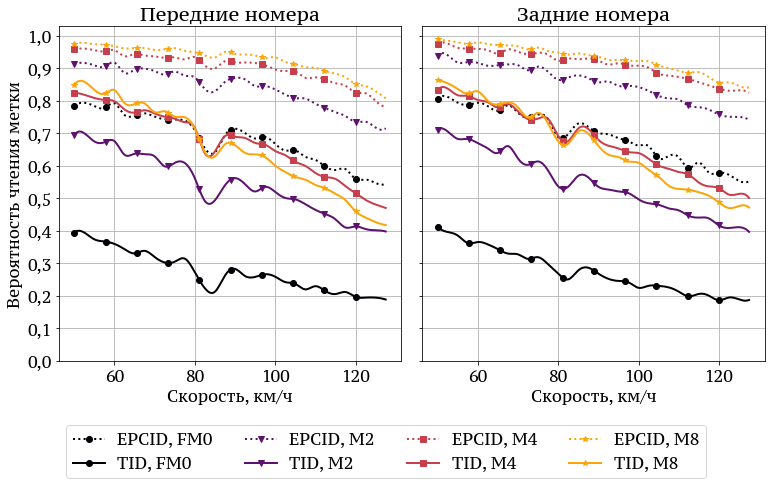

In [50]:
def plot_probs_for_m(
        image_name: str = "",
        tari: float = 12.5e-6
) -> None:
    """
    Нарисовать графики зависимости вероятности идентификации от скорости
    при различных значениях M.
    
    Args:
        image_name (str): имя файла без расширения
        tari (flaot): значение Tari в секундах (по-умолчанию, 12.5e-6)
    """
    fig, (ax0, ax1) = plt.subplots(figsize=(11, 6), ncols=2, sharey=True)
    
    df = DF[(DF.doppler) & (DF.tari == tari)].sort_values('speed')

    for i, m in enumerate(['FM0', 'M2', 'M4', 'M8']):
        for side, ax in zip(("front", "back"), (ax0, ax1)):
            dfi = df[(df.m == m) & (df.orientation == side)]
            ox = np.linspace(dfi.speed.min(), dfi.speed.max(), 300)
            oy_epc = interpolate(dfi.speed, dfi.inventory_prob, ox)
            oy_tid = interpolate(dfi.speed, dfi.read_tid_prob, ox)
            props = {
                'color': get_color(i / 3 * 0.8),
                'marker': MARKERS[i],
                'markersize': 6,
                'markevery': 30,
                'linewidth': 2,
            }
            ax.plot(ox, oy_epc, ':', label=f"EPCID, {m}", **props)
            ax.plot(ox, oy_tid, '-', label=f"TID, {m}", **props)

    ax0.set_title('Передние номера')
    ax0.set_ylabel('Вероятность чтения метки')
    ax1.set_title('Задние номера')
    
    for ax in (ax0, ax1):
        ax.grid()
        ax.set_ybound(lower=0)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.set_xlabel('Скорость, км/ч')
    
    fig.legend(*ax0.get_legend_handles_labels(), loc='lower center', 
               bbox_to_anchor=(0.5, -0.15), ncol=4)
    
    plt.tight_layout()
    savefig(image_name)

plot_probs_for_m("ch2_tag_identification_tari125")

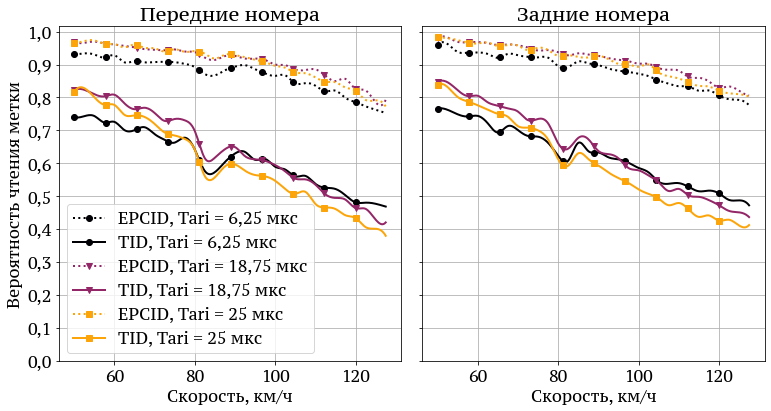

In [51]:
def plot_probs_for_tari(
        image_name: str = "",
        m: int = "M4"
) -> None:
    """
    Нарисовать графики зависимости вероятности идентификации от скорости
    при различных значениях Tari.
    
    Args:
        image_name (str): имя файла без расширения
        m (str): значение M из CSV-файла ("FM0", "M2", "M4", "M8")
    """
    fig, (ax0, ax1) = plt.subplots(figsize=(11, 6), ncols=2, sharey=True)

    df = DF[(DF.doppler) & (DF.m == m)].sort_values('speed')

    for i, tari in enumerate([6.25e-6, 18.75e-6, 25e-6]):
        tari_us = tari * 1e6
        for side, ax in zip(("front", "back"), (ax0, ax1)):
            dfi = df[(df.tari == tari) & (df.orientation == side)]
            ox = np.linspace(dfi.speed.min(), dfi.speed.max(), 300)
            oy_epc = interpolate(dfi.speed, dfi.inventory_prob, ox)
            oy_tid = interpolate(dfi.speed, dfi.read_tid_prob, ox)    
            props = {
                'color': get_color(i / 2 * 0.8),
                'marker': MARKERS[i],
                'markersize': 6,
                'markevery': 30,
                'linewidth': 2,
            }
            ax.plot(ox, oy_epc, ':', label=f"EPCID, Tari = {tari_us:n} мкс", 
                    **props)
            ax.plot(ox, oy_tid, '-', label=f"TID, Tari = {tari_us:n} мкс", 
                    **props)

    ax0.set_title('Передние номера')
    ax0.set_ylabel('Вероятность чтения метки')
    ax1.set_title('Задние номера')
    
    for ax in (ax0, ax1):
        ax.grid()
        ax.set_ybound(lower=0)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.set_xlabel('Скорость, км/ч')
    
    ax0.legend()
    plt.tight_layout()
    savefig(image_name)

plot_probs_for_tari("ch2_tag_identification_m4")

## Вероятность идентификации автомобиля

Будем считать, что автомобиль идентифицируется, если прочитана хотя бы одна
метка (передняя или задняя).

In [52]:
VEHICLE_PROB_SERIES = [
    [12.5e-6, "M2"],
    [12.5e-6, "M4"],
    [12.5e-6, "M8"],
    [25e-6, "M4"]
]

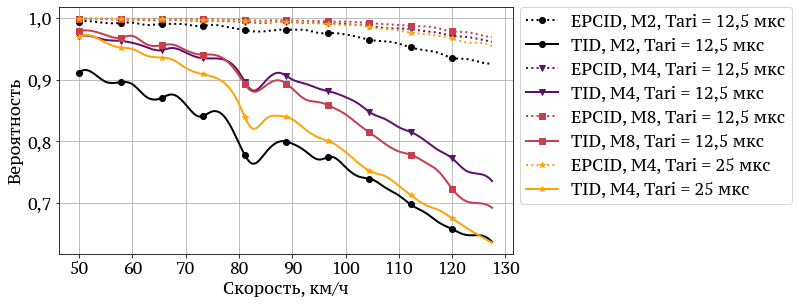

In [53]:
def plot_vehicle_probs(image_name: str = "") -> None:
    """
    Нарисовать вероятность идентификации автомобиля по любой из меток.
    
    Args:
        image_name (str): имя файла без расширения
    """
    fig, ax = plt.subplots(figsize=(7.5, 4.5))
    df = DF[DF.doppler].sort_values('speed')
    
    for i, (tari, m) in enumerate(VEHICLE_PROB_SERIES):
        dfi = df[(df.tari == tari) & (df.m == m)]
        speed = dfi.speed.unique()
        fronts = dfi[dfi.orientation == 'front']
        backs = dfi[dfi.orientation == 'back']

        epc_prob = []
        tid_prob = []
        for v in speed:
            front_epc_prob = fronts[fronts.speed == v].iloc[0].inventory_prob
            back_epc_prob = backs[backs.speed == v].iloc[0].inventory_prob
            front_tid_prob = fronts[fronts.speed == v].iloc[0].read_tid_prob
            back_tid_prob = backs[backs.speed == v].iloc[0].read_tid_prob
            a_epc_prob = 1 - (1 - front_epc_prob) * (1 - back_epc_prob)
            a_tid_prob = 1 - (1 - front_tid_prob) * (1 - back_tid_prob)
            epc_prob.append(a_epc_prob)
            tid_prob.append(a_tid_prob)

        ox = np.linspace(speed.min(), speed.max(), 300)
        oy_epc = interpolate(speed, epc_prob, ox)
        oy_tid = interpolate(speed, tid_prob, ox)

        props = {
            'color': get_color(i / (len(VEHICLE_PROB_SERIES)-1) * 0.8),
            'marker': MARKERS[i],
            'markersize': 6,
            'markevery': 30,
            'linewidth': 2,
        }
        epc_label = f"EPCID, {m}, Tari = {tari*1e6:n} мкс"
        tid_label = f"TID, {m}, Tari = {tari*1e6:n} мкс"
            
        ax.plot(ox, oy_epc, ':', **props, label=epc_label)
        ax.plot(ox, oy_tid, '-', **props, label=tid_label)

    ax.set_ylabel('Вероятность')
    ax.set_xlabel('Скорость, км/ч')
    ax.grid()
    
    fig.legend(*ax.get_legend_handles_labels(), loc="center right",
               bbox_to_anchor=(1.5, 0.645))
    plt.tight_layout()

plot_vehicle_probs("ch2_vehicle_identification_rate")

## Влияние эффекта Доплера

Сравним вероятность идентификации передних и задних номеров, рассчитанную
с учетом и без эффекта Доплера.

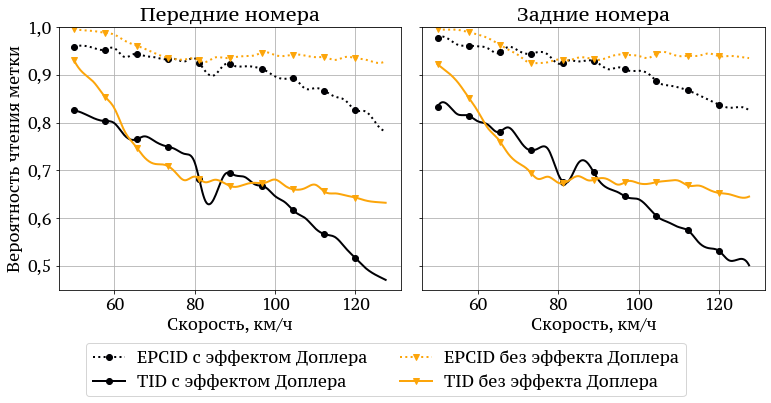

In [54]:
def plot_dopler_effect(
        image_name: str = "",
        m: str = "M4",
        tari: float = 12.5e-6
) -> None:
    """
    Нарисовать вероятности чтения меток с учетом и без эффекта Доплера,
    отдельно для передних и задних номеров.
    
    Args:
        image_name (str): имя файла без расширения
        m (str): значение M ("FM0", "M2", "M4", "M8")
        tari (float): значение Tari в секундах
    """
    fig, (ax0, ax1) = plt.subplots(figsize=(11, 5), ncols=2, sharey=True)
    df = DF[(DF.m == m) & (DF.tari == tari)].sort_values('speed')
    
    for i, doppler in enumerate([True, False]):
        doppler_str = "с эффектом Доплера" if doppler else "без эффекта Доплера"
        for side, ax in zip(("front", "back"), (ax0, ax1)):
            dfi = df[(df.doppler == doppler) & (df.orientation == side)]
            
            ox = np.linspace(dfi.speed.min(), dfi.speed.max(), 300)
            oy_epc = interpolate(dfi.speed, dfi.inventory_prob, ox)
            oy_tid = interpolate(dfi.speed, dfi.read_tid_prob, ox)
            
            props = {
                'color': get_color(i * 0.8),
                'marker': MARKERS[i],
                'markersize': 6,
                'markevery': 30,
                'linewidth': 2,
            }
            
            ax.plot(ox, oy_epc, ':', **props, label=f"EPCID {doppler_str}")
            ax.plot(ox, oy_tid, '-', **props, label=f"TID {doppler_str}")

    ax0.set_title('Передние номера')
    ax0.set_ylabel('Вероятность чтения метки')
    ax1.set_title('Задние номера')
    
    for ax in (ax0, ax1):
        ax.grid()
        ax.set_ybound(lower=0)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.set_xlabel('Скорость, км/ч')
        ax.set_ylim((0.45, 1.0))
    
    fig.legend(*ax0.get_legend_handles_labels(), loc="lower center",
               bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    savefig(image_name)            

plot_dopler_effect("ch2_identification_doppler")

## Число раундов, в которых участвует метка

Этот эксперимент проводился отдельно. В нем рассматривалась однополосная дорога,
одна или две антенны.

In [55]:
ANTENNA_SWITCH_DATA = [{
    "scenario": "A",
    "ant": 2,
    "x": [2, 4.044, 5.7, 7.467, 10.518, 13.45, 16.223, 30.063, 56.526],
    "y": [12.38, 11.8, 10.8, 10.18, 9.06, 8.18, 7.84, 5.96, 4.54],
}, {
    "scenario": "AB",
    "ant": 2,
    "x": [2, 3.938, 5.959, 7.741, 11.964, 16.130, 18.479, 39.695, 56.526],
    "y": [7.2, 11.3, 11.2, 10.88, 11.12, 10.88, 10.54, 11.2, 10.98],
}, {
    "scenario": "AB",
    "ant": 1,    
    "x": [2.00, 56.526],
    "y": [9.02, 9.02]
}, {
    "scenario": "A",
    "ant": 1,    
    "x": [2.00, 56.526],
    "y": [4.4, 4.4],
}]

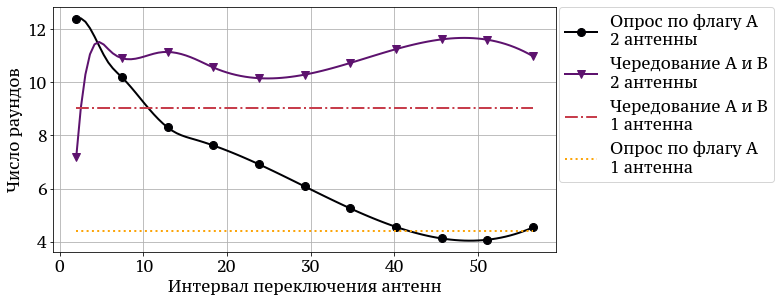

In [58]:
def plot_num_rounds_per_tag(image_name: str = "") -> None:
    """
    Нарисовать зависимость числа раундов, в которых метка принимает участие,
    от сценария опроса и числа антенн.
    
    Args:
        image_name (str): название файла без расширения
    """
    fig, ax = plt.subplots(figsize=(9, 4.5))
    min_x = min([it['x'][0] for it in ANTENNA_SWITCH_DATA])
    max_x = max([it['x'][-1] for it in ANTENNA_SWITCH_DATA])
    interp_ox = np.linspace(min_x, max_x, 101)
    dotted_linestyles = [':', '-.', '-.']
    
    for i, item in enumerate(ANTENNA_SWITCH_DATA):
        if len(item['x']) < 3:
            ox = item['x']
            oy = item['y']
            linestyle = dotted_linestyles[i % len(dotted_linestyles)]
            marker = ''
            markersize = 0
            markevery = 0
        else:
            ox = interp_ox
            oy = interpolate(item['x'], item['y'], interp_ox)
            linestyle = '-'
            marker = MARKERS[i]
            markersize = 8
            markevery = 10
        
        scenario = "Опрос по флагу A" if item["scenario"] == "A" else \
            "Чередование A и B"
        antennas = "1 антенна" if item['ant'] == 1 else f"{item['ant']} антенны"
        color = get_color(i / (len(ANTENNA_SWITCH_DATA)-1) * 0.8)

        ax.plot(ox, oy, linestyle, label=f"{scenario}\n{antennas}", color=color,
                marker=marker, markersize=markersize, markevery=markevery,
                linewidth=2)
    
    ax.grid()
    ax.set_xlabel("Интервал переключения антенн")
    ax.set_ylabel("Число раундов")
    fig.legend(*ax.get_legend_handles_labels(), loc='center right',
               bbox_to_anchor=(1.25, 0.61))
    savefig(image_name)
    
plot_num_rounds_per_tag("ch2_sim_num_rounds_one_lane")